In [1]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
%matplotlib inline

sns.set()
sns.set_context('talk')
pd.options.display.max_rows = 7
pd.options.display.max_columns = 7
np.set_printoptions(precision=2, suppress=True)

In [2]:
# HIDDEN
"""
def minimize(cost_fn, grad_cost_fn, X, y, alpha=0.2, progress=True):
    '''
    Uses gradient descent to minimize cost_fn. Returns the minimizing value of
    theta once theta changes less than 0.001 between iterations.
    '''
    theta = np.zeros(X.shape[1])
    old_cost = 10000000
    while True:
        if progress:
            print(f'theta: {theta} | cost: {cost_fn(theta, X, y):.2f}')
        gradient = grad_cost_fn(theta, X, y)
        new_theta = theta - alpha * gradient
        cost = cost_fn(theta, X, y)
        if abs(old_cost - cost) < 10:
            return new_theta
        old_cost = cost
        
        theta = new_theta
        
"""
        
from scipy.optimize import minimize as sci_min

def minimize(cost_fn, grad_cost_fn, X, y, progress=True):
    '''
    Uses scipy.minimize to minimize cost_fn using a form of gradient descent.
    '''
    theta = np.zeros(X.shape[1])
    iters = 0
    
    def objective(theta):
        return cost_fn(theta, X, y)
    def gradient(theta):
        return grad_cost_fn(theta, X, y)
    def print_theta(theta):
        nonlocal iters
        if progress and iters % progress == 0:
            print(f'theta: {theta} | cost: {cost_fn(theta, X, y):.2f}')
        iters += 1
        
    print_theta(theta)
    return sci_min(
        objective, theta, method='BFGS', jac=gradient, callback=print_theta,
        tol=1e-7
    ).x

## Linear Regression Case Study

In this section, we perform an end-to-end case study of the application of a linear regression model to a dataset.

The dataset we will be working with is a record of the population and drinking data in various states. The dataset is from this website: http://people.sc.fsu.edu/~jburkardt/datasets/regression/x20.txt, with some properties of the dataset changed for didactical purposes.

Our task: predict the cirrhosis death rate using linear regression.

## Exploring the Dataset

As in any data science project, we'll begin with exploratory data analysis.

We'll start by reading in the dataset using `pandas`.

In [3]:
drinking_data = pd.read_csv("drinking.csv")

It's always a good idea to look at _how much_ data we have by looking at the dimensions of the dataset. An example of how this might be useful: if our data has a large number of observations, it would not be a good idea to print out the whole dataframe.

In [4]:
drinking_data.shape

(46, 6)

The dataset is small, with only 46 rows of observations and 6 columns. Let's look at what columns we have available to us.

In [5]:
drinking_data.columns.values

array(['Bias', 'Urban population (percentage)',
       'Late births (reciprocal * 100)', 'Wine consumption per capita',
       'Liquor consumption per capita', 'Cirrhosis death rate'], dtype=object)

But what do any of these column names mean? Just looking at the column names is not enough because they may be unclear and our assumptions of what they mean can be wrong. Looking at the documentation provided by the source of the dataset, we can create a table describing each column, sometimes referred to as a data dictionary:

| Column        | Description   
| :------------- |:-------------|
|`'Bias'`| a column of all 1's |
|`'Urban population (percentage)'`| the size of the urban population | 
|`'Late births (reciprocal * 100)'`| the reciprocal of the number of births to women between 45 to 49, times 100 |
|`'Wine consumption per capita'`| the consumption of wine per capita|
|`'Liquor consumption per capita'`| the consumption of hard liquor per capita|
|`'Cirrhosis death rate'`| the death rate from cirrhosis |

At this point, we may want to look up words we do not understand. For example, a quick Google search reveals that cirrhosis is chronic liver disease and can be caused by chronic alcohol abuse. Some of these column names are really long, so it may be convenient to rename some of them later.

Now that we have a good understanding of each of the columns, we can actually start to look at the data. Let's take a quick look at the first few rows of our dataset using the `head` function. 

In [6]:
drinking_data.head()

,Bias,Urban population (percentage),Late births (reciprocal * 100),Wine consumption per capita,Liquor consumption per capita,Cirrhosis death rate
0,1,44.0,33.2,5,30,41.2
1,1,43.0,33.8,4,41,31.7
2,1,48.0,40.6,3,38,39.4
3,1,52.0,39.2,7,48,57.5
4,1,71.0,45.5,11,53,74.8


Although we cannot see any null values from the first 5 rows of the dataset, there may be some present in our dataset that we will need to deal with. We can write code to tell us if there are null values present using the pandas `isnull` function.

In [15]:
num_nulls = drinking_data.isnull().sum(axis=1) # summing over axis = 1 tells us the number of null values per row
num_nulls[num_nulls > 0]

35    1
dtype: int64

It appears that there is a null value present in row 35 of our dataset. Let's examine that row more closely:

In [16]:
drinking_data.iloc[35]

Bias                                1.0
Urban population (percentage)       NaN
Late births (reciprocal * 100)     53.0
Wine consumption per capita        28.0
Liquor consumption per capita     149.0
Cirrhosis death rate              122.5
Name: 35, dtype: float64

With null values, we have two options: either drop the row with the null value or try to impute a value in the place of the null. Since we only have one null value in our dataset and it may not be a good idea to try to guess a value because it may negatively influence our linear regression model, we can just drop the row.

## Data Cleaning

Let's rename the column names to shorter names. It will make our code look cleaner and easier to read. We can make a new list of column names and assign `drinking_data.columns` to this list.

In [22]:
new_column_names = ['Bias', 'Urban population', 'Late births', 'Wine', 'Liquor', 'Cirrhosis']
drinking_data.columns = new_column_names 

In [23]:
drinking_data

,Bias,Urban population,Late births,Wine,Liquor,Cirrhosis
0,1,44.0,33.2,5,30,41.2
1,1,43.0,33.8,4,41,31.7
2,1,48.0,40.6,3,38,39.4
...,...,...,...,...,...,...
43,1,44.0,35.3,3,32,51.6
44,1,63.0,39.3,8,40,55.7
45,1,58.0,43.8,13,57,55.5


Let's deal with that pesky null value. 

In [24]:
drinking_data = drinking_data.dropna()
drinking_data

,Bias,Urban population,Late births,Wine,Liquor,Cirrhosis
0,1,44.0,33.2,5,30,41.2
1,1,43.0,33.8,4,41,31.7
2,1,48.0,40.6,3,38,39.4
...,...,...,...,...,...,...
43,1,44.0,35.3,3,32,51.6
44,1,63.0,39.3,8,40,55.7
45,1,58.0,43.8,13,57,55.5


Looks like it worked! We now have 45 rows instead of 46 rows. 

## Data Visualization

If we are going to try to create a _linear_ model, we should make sure that all of our predictor variables have a somewhat linear relationship with the target variable of Cirrhosis. Let's plot every predictor variable individually against Cirrhosis.  

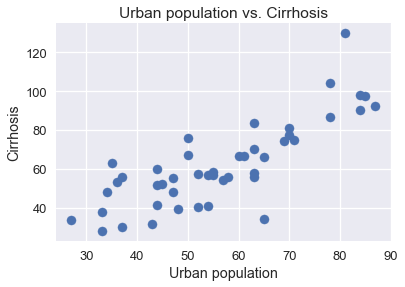

In [25]:
# HIDDEN
plt.scatter(drinking_data['Urban population'], drinking_data['Cirrhosis'])
plt.title("Urban population vs. Cirrhosis")
plt.xlabel("Urban population")
plt.ylabel("Cirrhosis");

This looks like reasonably linear.

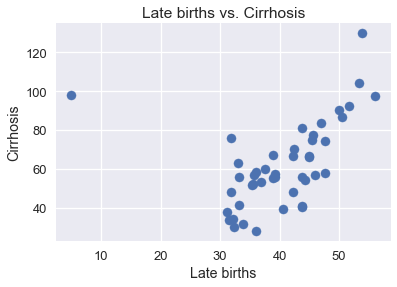

In [26]:
# HIDDEN
plt.scatter(drinking_data['Late births'], drinking_data['Cirrhosis'])
plt.title("Late births vs. Cirrhosis")
plt.xlabel("Late births")
plt.ylabel("Cirrhosis");

It looks like we have an outlier for late births. Late births and cirrhosis seem to have a pretty strong linear relationship, but because this point is not close to the linear trend at all, this outlier would negatively affect our linear regression model. Thus, we should take this row out of our dataset. 

Since we can easily see that this lates births value is less than 10, we can just filter our dataset by selecting only rows where late births is over 10.

In [27]:
drinking_data = drinking_data[drinking_data['Late births'] >= 10]
drinking_data

,Bias,Urban population,Late births,Wine,Liquor,Cirrhosis
0,1,44.0,33.2,5,30,41.2
1,1,43.0,33.8,4,41,31.7
2,1,48.0,40.6,3,38,39.4
...,...,...,...,...,...,...
43,1,44.0,35.3,3,32,51.6
44,1,63.0,39.3,8,40,55.7
45,1,58.0,43.8,13,57,55.5


How does our scatterplot look now without that outlier?

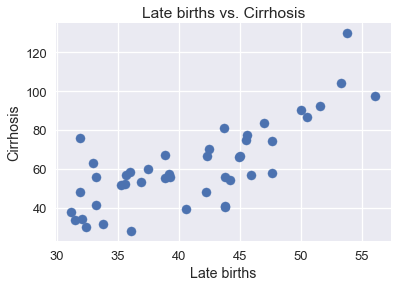

In [28]:
# HIDDEN
plt.scatter(drinking_data['Late births'], drinking_data['Cirrhosis'])
plt.title("Late births vs. Cirrhosis")
plt.xlabel("Late births")
plt.ylabel("Cirrhosis");

Much better!

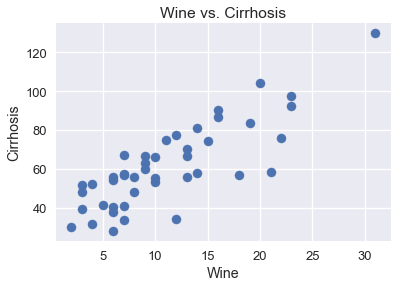

In [29]:
# HIDDEN
plt.scatter(drinking_data['Wine'], drinking_data['Cirrhosis'])
plt.title("Wine vs. Cirrhosis")
plt.xlabel("Wine")
plt.ylabel("Cirrhosis");

This looks like a pretty strong linear relationship between wine and cirrhosis.

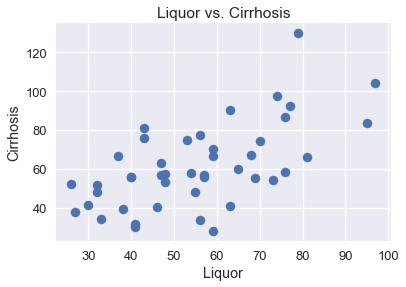

In [30]:
# HIDDEN
plt.scatter(drinking_data['Liquor'], drinking_data['Cirrhosis'])
plt.title("Liquor vs. Cirrhosis")
plt.xlabel("Liquor")
plt.ylabel("Cirrhosis");

There seems to be a somewhat linear relationship between liquor and cirrhosis, though it is definitely not as strong as that between wine and cirrhosis.

## Linear Regression Model

Since all variables seem to have a linear relationship with cirrhosis, we can just include all of them in our model. 

Our model looks like this:

$$
f_\hat{\theta} (x) = \hat{\theta_0} + \hat{\theta_1} (Urban population) + \hat{\theta_2} (Late births) + \hat{\theta_3} (Wine) + \hat{\theta_3} (Liquor)
$$

Remember, the $\hat{\theta_0}$ is accounted for due to the bias column in our dataframe.

Here are the functions we defined earlier in the multiple linear regression section, which we will use again:

In [31]:
def linear_model(thetas, X):
    '''Returns predictions by a linear model on x_vals.'''
    return X @ thetas

def mse_cost(thetas, X, y):
    return np.mean((y - linear_model(thetas, X)) ** 2)

def grad_mse_cost(thetas, X, y):
    n = len(X)
    return -2 / n * (X.T @ y  - X.T @ X @ thetas)

In order to use the above functions, we need `X`, and `y`. These can both be obtained from our dataframe. Remember that `X` and `y` have to be numpy matrices in order to be able to multiply them with `@` notation.

`X` consists of all columns of the dataframe except for the target column, `Cirrhosis`. 

In [32]:
X = (drinking_data
     .loc[:, ['Bias', 'Urban population', 'Late births', 'Wine', 'Liquor' ]]
     .as_matrix())

`y` consists of the `Cirrhosis` column of our dataset.

In [33]:
y = drinking_data['Cirrhosis'].as_matrix()

Now we just need to call the `minimize` function defined in a previous section.

In [34]:
thetas = minimize(mse_cost, grad_mse_cost, X, y)

theta: [ 0.  0.  0.  0.  0.] | cost: 4217.20
theta: [ 0.01  0.64  0.45  0.14  0.63] | cost: 999.01
theta: [ 0.    1.    0.39  0.59  0.21] | cost: 955.60
theta: [-0.02  0.86  0.1   1.58  0.34] | cost: 902.97
theta: [-0.01  0.41  0.82  2.13  0.13] | cost: 809.45
theta: [-0.08  0.55  0.54  1.86  0.19] | cost: 634.59
theta: [-0.33  0.43  0.63  1.86  0.11] | cost: 339.56
theta: [-1.26  0.22  0.76  1.8  -0.01] | cost: 98.33
theta: [-3.18  0.2   0.85  1.81 -0.02] | cost: 97.67
theta: [-7.49  0.17  1.01  1.81 -0.04] | cost: 96.69
theta: [-11.19   0.14   1.16   1.81  -0.05] | cost: 96.43
theta: [-11.19   0.14   1.16   1.81  -0.05] | cost: 96.43
theta: [-11.19   0.14   1.16   1.81  -0.05] | cost: 96.43
theta: [-11.19   0.14   1.16   1.81  -0.05] | cost: 96.43


Looks like gradient descent converged to those theta values! Thus, our linear model is:

$y = -11.19 + 0.14x_1 + 1.16x_2 + 1.81x_3 - 0.05x_4$

Let's compare this equation that we obtained to the one we would get if we had used `sklearn`'s LinearRegression model instead. The LinearRegression model automatically includes a column of all 1's in our data, so we can get rid of our column of 1's when we pass `X` into the `fit` function.

In [36]:
model = LinearRegression()
model.fit(X[:, 1:], y)
print("Coefficients", model.coef_)
print("Intercept", model.intercept_)

Coefficients [ 0.14  1.16  1.81 -0.05]
Intercept -11.1877734159


The coefficients look pretty similar! Our homemade functions create the same model as an established Python package!

## Evaluating our Model

Now that we have a model, let's see how well it does on our dataset by plotting a residual plot of the percent error between the predicted Cirrhosis death rate values and the actual Cirrhosis death rate values.

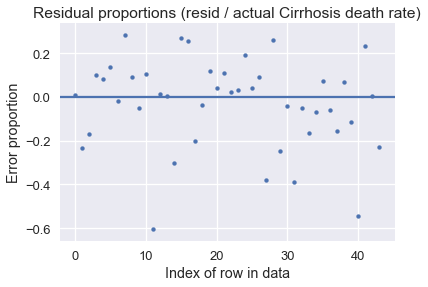

In [78]:
# HIDDEN
resid = y - linear_model(thetas, X)
resid_prop = resid / drinking_data['Cirrhosis']
plt.scatter(np.arange(len(resid_prop)), resid_prop, s=15)
plt.axhline(0)
plt.title('Residual proportions (resid / actual Cirrhosis death rate)')
plt.xlabel('Index of row in data')
plt.ylabel('Error proportion');

Looks like our linear model does pretty well when it predicts something higher than the actual value (it is usually within 25% of the correct value), but our model can do pretty abysmally when it predicts something lower than the actual value (there are a good number of error proportions around and above 30%). 

As we can tell from the residual plot, our model is subpar. We can hypothesize why our model is not doing well:

1) We don't have enough data (only 44 rows of observations)

2) A better model fits the data.

Regardless, we have successfully fit a linear regression model to the data! Nice!